In [1]:
import torch.nn as nn
import torch
from torch import Tensor
from typing import Type
from torchinfo import summary
from torchvision.ops import FeaturePyramidNetwork
from torchvision.models import resnet18
from gfl_head_reduced import GFLHead
from collections import OrderedDict

In [2]:
class BasicBlock(nn.Module):
    
    def __init__(self, in_channels: int, out_channels: int, stride: int = 1, expansion: int = 1, downsample: nn.Module = None) -> None:
        super(BasicBlock, self).__init__()
        # Multiplicative factor for the subsequent conv2d layer's output channels. It is 1 for ResNet18 and ResNet34.
        self.expansion = expansion
        self.downsample = downsample
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels*self.expansion, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels*self.expansion)

    def forward(self, x: Tensor) -> Tensor:
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)
            
        out += identity
        out = self.relu(out)
        return  out

In [3]:
class ResNet(nn.Module):

    def __init__(self, img_channels: int, num_layers: int, block: Type[BasicBlock], num_classes: int  = 1000) -> None:
        super(ResNet, self).__init__()

        # The following `layers` list defines the number of `BasicBlock` to use to build the network and how many basic blocks to stack together.
        if num_layers == 18:
            layers = [2, 2, 2, 2]
            self.expansion = 1
        
        self.in_channels = 64
        # All ResNets (18 to 152) contain a Conv2d => BN => ReLU for the first three layers. Here, kernel size is 7.
        self.conv1 = nn.Conv2d(in_channels=img_channels,out_channels=self.in_channels, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512*self.expansion, num_classes)

    def _make_layer(self, block: Type[BasicBlock], out_channels: int, blocks: int, stride: int = 1) -> nn.Sequential:
        downsample = None
        if stride != 1:
            """
            This should pass from `layer2` to `layer4` or when building ResNets50 and above. Section 3.3 of the paper Deep Residual Learning for Image Recognition
            (https://arxiv.org/pdf/1512.03385v1.pdf).
            """
            downsample = nn.Sequential(
                nn.Conv2d(
                    self.in_channels, 
                    out_channels*self.expansion,
                    kernel_size=1,
                    stride=stride,
                    bias=False 
                ),
                nn.BatchNorm2d(out_channels * self.expansion),
            )
        layers = []
        layers.append(
            block(
                self.in_channels, out_channels, stride, self.expansion, downsample
            )
        )
        self.in_channels = out_channels * self.expansion
        for i in range(1, blocks):
            layers.append(block(
                self.in_channels,
                out_channels,
                expansion=self.expansion
            ))
        return nn.Sequential(*layers)
    def forward(self, x: Tensor) -> Tensor:
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        # The spatial dimension of the final layer's feature 
        # map should be (7, 7) for all ResNets.
        features = x
        print('Dimensions of the last convolutional feature map: ', x.shape)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x, features

CoarseDet: <br>
   backbone = Resnet50<br>
   neck = FPN in_channels=[256, 512, 1024, 2048],  out_channels=256,start_level=1,add_extra_convs='on_output', num_outs=5),<br>
   head = GFL (num_classes=10, in_channels=256, stacked_convs=4,  feat_channels=256)<br>
   anchor_generator=dict(type='AnchorGenerator', ratios=[1.0],octave_base_scale=8,   scales_per_octave=1, strides=[8, 16, 32, 64, 128]),<br>
        loss_cls=dict(type='QualityFocalLoss',   use_sigmoid=True,   beta=2.0,loss_weight=1.0),<br>
        loss_dfl=dict(type='DistributionFocalLoss', loss_weight=0.25),<br>
        reg_max=16,<br>
        loss_bbox=dict(type='GIoULoss', loss_weight=2.0) <br>


In [4]:
class AerialDet(nn.Module):
    
    def __init__(self, num_classes=10):
        
        super(AerialDet, self).__init__()

        backbone = resnet18(weights='IMAGENET1K_V1')
        self.neck = FeaturePyramidNetwork([64, 64, 128, 256, 512], 64)
        self.backbone = nn.Sequential(*list(backbone.children())[:-2])
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        #self.neck = nn.Sequential(*list(neck.children())[:-2])
        self.head = GFLHead(num_classes, None, 256,feat_channels=256, stacked_convs=4,octave_base_scale=8,  strides=[8, 16, 32, 64, 128], reg_max=16)
        self.classifier = nn.Linear(64, num_classes)  # 2048 is the feature size of ResNet50's last conv layer

    def forward(self, x):
        # Extract feature maps from ResNet layers
        feature_maps = OrderedDict()

        for i, layer in enumerate([self.backbone[0:4], #Conv_1 
                                   self.backbone[4],   #Conv_2_x 
                                   self.backbone[5],   #Conv3_x
                                   self.backbone[6],   #Conv4_x
                                   self.backbone[7]]): #Conv5_x            
            x = layer(x)
            #print("Stage ",i," has output shape", x.shape)
            feature_maps[str(i)] = x
        
        # Pass through FPN and classify
        fpn_output = self.neck(feature_maps)
        print(fpn_output.keys())
        pooled = self.global_avg_pool(fpn_output['0'])
        return self.classifier(torch.flatten(pooled, 1))

# Instantiate the model
model = AerialDet(num_classes=10)

# Create dummy input tensor
input_tensor = torch.randn(1, 3, 224, 224)  # (batch_size, channels, height, width)

# Forward pass
output = model(input_tensor)

odict_keys(['0', '1', '2', '3', '4'])


In [5]:
summary(model, input_size=(1, 3, 720, 1280))

odict_keys(['0', '1', '2', '3', '4'])


Layer (type:depth-idx)                        Output Shape              Param #
AerialDet                                     [1, 10]                   2,612,819
├─Sequential: 1-1                             --                        --
│    └─Conv2d: 2-1                            [1, 64, 360, 640]         9,408
│    └─BatchNorm2d: 2-2                       [1, 64, 360, 640]         128
│    └─ReLU: 2-3                              [1, 64, 360, 640]         --
│    └─MaxPool2d: 2-4                         [1, 64, 180, 320]         --
│    └─Sequential: 2-5                        [1, 64, 180, 320]         --
│    │    └─BasicBlock: 3-1                   [1, 64, 180, 320]         73,984
│    │    └─BasicBlock: 3-2                   [1, 64, 180, 320]         73,984
│    └─Sequential: 2-6                        [1, 128, 90, 160]         --
│    │    └─BasicBlock: 3-3                   [1, 128, 90, 160]         230,144
│    │    └─BasicBlock: 3-4                   [1, 128, 90, 160]        

# VisDrone Coarse

In [6]:
import os
import json

path = "/media/mabr/DATASETS/VisDrone/COCO/"

for filename in os.listdir(path):
   if('train.json' in filename):
      stage = filename[:-5]
      print("---", stage, "----")
      print(path+filename)
      with open(path+filename, 'r') as j:
         contents = json.loads(j.read())

--- train ----
/media/mabr/DATASETS/VisDrone/COCO/train.json


In [7]:
contents['categories']

[{'supercategory': 'none', 'id': 0, 'name': 'pedestrian'},
 {'supercategory': 'none', 'id': 1, 'name': 'people'},
 {'supercategory': 'none', 'id': 2, 'name': 'bicycle'},
 {'supercategory': 'none', 'id': 3, 'name': 'car'},
 {'supercategory': 'none', 'id': 4, 'name': 'van'},
 {'supercategory': 'none', 'id': 5, 'name': 'truck'},
 {'supercategory': 'none', 'id': 6, 'name': 'tricycle'},
 {'supercategory': 'none', 'id': 7, 'name': 'awning-tricycle'},
 {'supercategory': 'none', 'id': 8, 'name': 'bus'},
 {'supercategory': 'none', 'id': 9, 'name': 'motor'}]

(540, 960, 3)


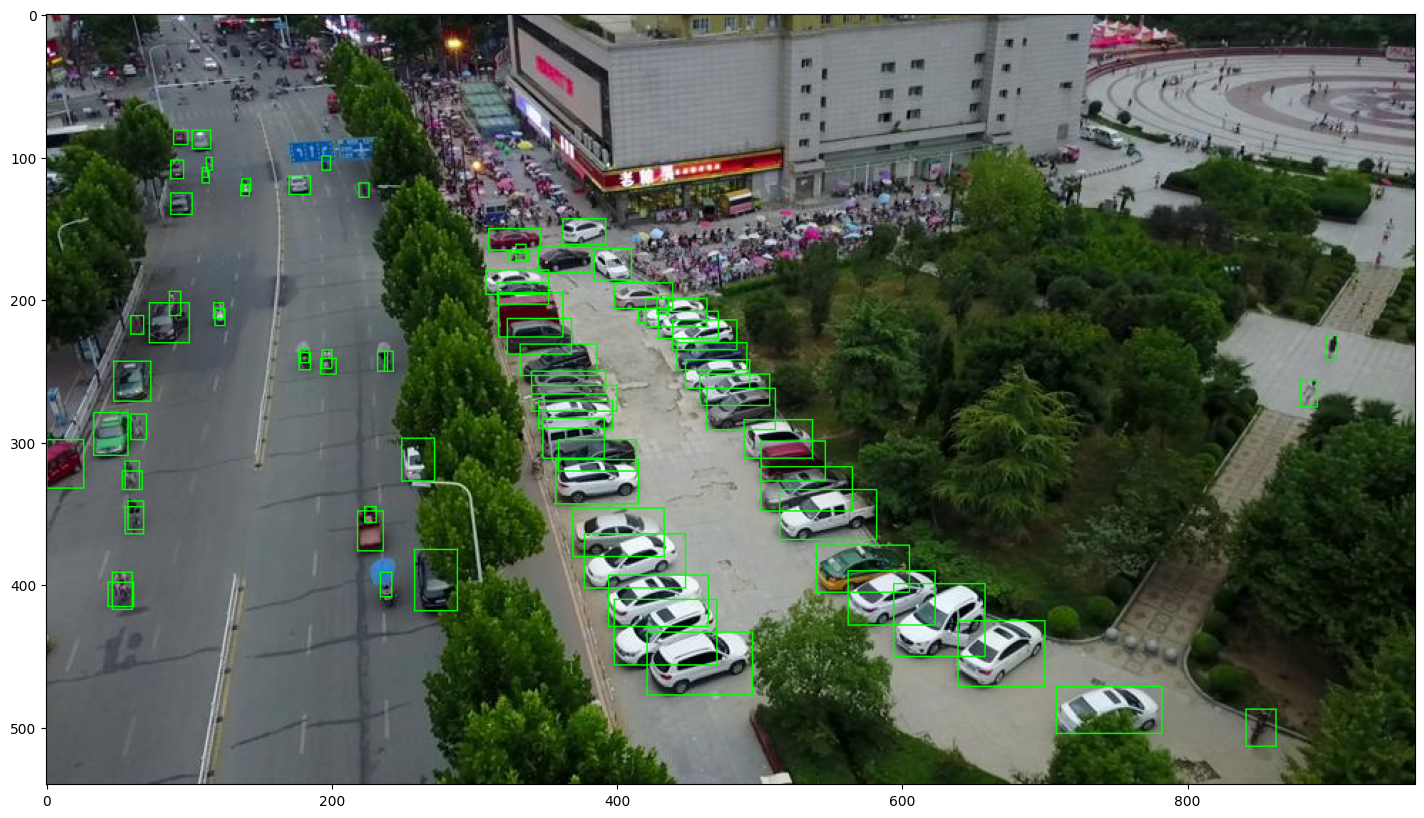

In [8]:
%matplotlib inline 

from ufp import UnifiedForegroundPacking
import cv2 
import matplotlib.pyplot as plt
import numpy as np

bbox_list = []

for imageID in range(0,1):
   image = contents['images'][imageID]
   anno = contents['annotations']
   imgpath = '/media/mabr/DATASETS/VisDrone/VisDrone2019-DET-{0}/images/'.format(stage)

   img = cv2.imread(imgpath+ image['file_name'])
   img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
   print(img.shape)
   

   for inst in anno:

      if(inst['image_id']==imageID):
         bbox = inst['bbox']
         x,y,w,h = bbox
         bbox_list.append([x, y, x+w, y+h])
         img = cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255,0), 1)
      
   rec, new_w, new_h = UnifiedForegroundPacking(np.array(bbox_list), 1.5, (960, 540), output_shape=(960, 540)) #expects bboxes in xyxy

   plt.figure(figsize=(20,10))
   plt.imshow(img)

In [9]:
#Step 1: Take list of bounding boxes and extend the scale by beta (1.5 in paper worked best on VisDrone)
#Step 2: Select the box with smallest area as starting point
#Step 3: For all remaining bounding boxes:
#        a) if the area A+B is larger than C, C 

In [23]:
import math

def draw_ufp_result(results, img, w, h):
    w = math.ceil(w)
    h = math.ceil(h)

    new_img = np.zeros((h, w, 3))
    
    for result in results:
        x1, y1, w, h, n_x, n_y, scale_factor = [math.floor(_) for _ in result]
        if w == 0 or h == 0:
            continue
        new_img[n_y:n_y + h * scale_factor, n_x:n_x + w * scale_factor, :] = cv2.resize(img[y1:y1 + h, x1:x1 + w, :], (w * scale_factor, h * scale_factor))
    
    return new_img

In [24]:
ufp_img = draw_ufp_result(rec, img.copy(), new_w, new_h)

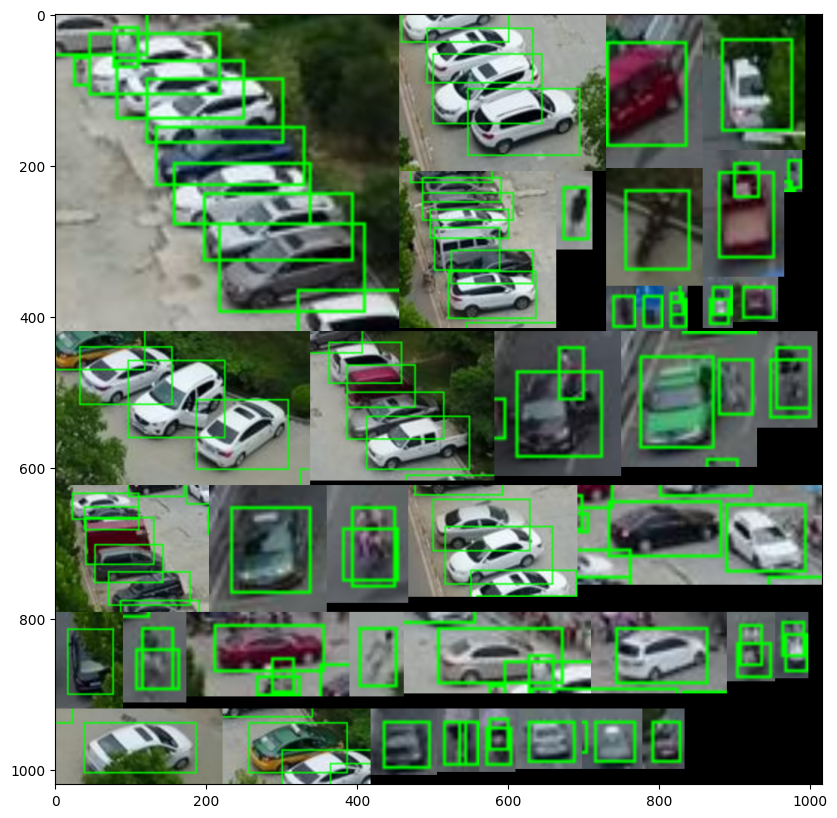

In [20]:
plt.figure(figsize=(20,10))
plt.imshow(ufp_img/255)

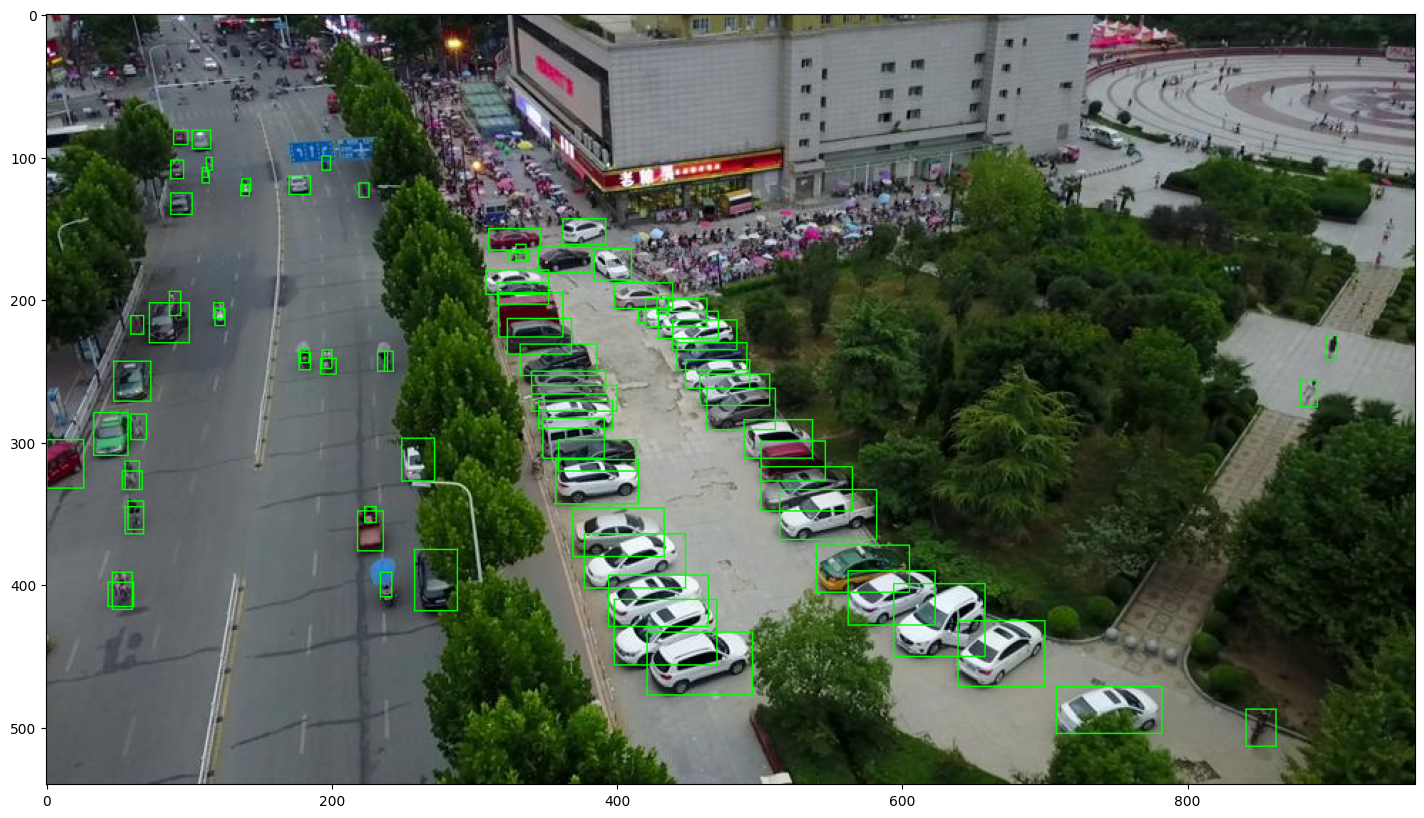

In [22]:
plt.figure(figsize=(20,10))
plt.imshow(img)

In [107]:
x,y,w,h = fgr[0:4]
new_img = cv2.rectangle(new_img, (x, y), (x+new_w, y+new_h), (255, 255,0), 1)